In [1]:
# imports
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns

from econml.dml import LinearDML
from econml.dr import LinearDRLearner
from econml.cate_interpreter import SingleTreeCateInterpreter
from econml.dml import CausalForestDML,NonParamDML

from sklearn.linear_model import LogisticRegressionCV, LinearRegression,LogisticRegression,Lasso,LassoCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,GradientBoostingClassifier
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from econml.sklearn_extensions.model_selection import GridSearchCVList


import matplotlib.pyplot as plt
from matplotlib.transforms import ScaledTranslation
import seaborn as sns

%matplotlib inline

### 处理数据

In [199]:
data=pd.read_excel("诸葛1129.xlsx")

In [200]:
data.describe()

,诸葛id,胆识联盟事件次数,凯迪拉克岛屿事件次数,凯迪音乐厅事件次数,时空瞭望塔事件次数,风范天地事件次数,凯迪拉克雪国战车事件次数,预约试驾-提交预约试驾事件次数,任务类型-爱车任务事件次数,任务类型-惊喜任务事件次数,任务中心-成功邀请好友事件次数,任务中心-获取克拉值事件次数,任务中心-进入用户调研页事件次数,任务中心-浏览车型主亮点事件次数,任务中心-签到事件次数,任务中心-邀请好友事件次数,进入数字展厅页事件次数
count,7.395460e+05,11943.000000,277592.000000,11495.000000,28846.000000,13581.000000,10082.000000,9369.000000,1.0,8.0,16473.000000,25030.000000,9089.000000,4971.000000,24196.000000,62.000000,151795.000000
mean,5.135650e+05,9.392531,10.591325,7.379034,4.223359,14.639791,4.477286,1.163518,1.0,1.0,2.182845,3.616740,1.045219,10.515993,2.516573,1.112903,3.453638
std,3.351558e+05,43.985376,729.721090,14.457896,16.140916,20.207797,15.480606,0.762981,NaN,0.0,9.762357,29.291216,0.232772,163.551291,6.930507,0.319058,28.822215
min,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.264412e+05,2.000000,1.000000,3.000000,2.000000,6.000000,2.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
50%,4.611575e+05,5.000000,3.000000,6.000000,3.000000,10.000000,3.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,2.000000
75%,7.911788e+05,9.000000,6.000000,9.000000,4.000000,18.000000,5.000000,1.000000,1.0,1.0,2.000000,3.000000,1.000000,8.000000,2.000000,1.000000,4.000000
max,1.176037e+06,3156.000000,318896.000000,1204.000000,2512.000000,840.000000,1381.000000,55.000000,1.0,1.0,951.000000,4443.000000,8.000000,11506.000000,146.000000,2.000000,10891.000000


In [201]:
data=data[pd.notna(data["诸葛id"])]

In [202]:
data.columns

Index(['诸葛id', '胆识联盟事件次数', '凯迪拉克岛屿事件次数', '凯迪音乐厅事件次数', '时空瞭望塔事件次数', '风范天地事件次数',
       '凯迪拉克雪国战车事件次数', '预约试驾-提交预约试驾事件次数', '任务类型-爱车任务事件次数', '任务类型-惊喜任务事件次数',
       '任务中心-成功邀请好友事件次数', '任务中心-获取克拉值事件次数', '任务中心-进入用户调研页事件次数',
       '任务中心-浏览车型主亮点事件次数', '任务中心-签到事件次数', '任务中心-邀请好友事件次数', '进入数字展厅页事件次数'],
      dtype='object')

In [203]:
data = data[[i for i in data.columns if  "时间" not in  i ]]
data.head()

,诸葛id,胆识联盟事件次数,凯迪拉克岛屿事件次数,凯迪音乐厅事件次数,时空瞭望塔事件次数,风范天地事件次数,凯迪拉克雪国战车事件次数,预约试驾-提交预约试驾事件次数,任务类型-爱车任务事件次数,任务类型-惊喜任务事件次数,任务中心-成功邀请好友事件次数,任务中心-获取克拉值事件次数,任务中心-进入用户调研页事件次数,任务中心-浏览车型主亮点事件次数,任务中心-签到事件次数,任务中心-邀请好友事件次数,进入数字展厅页事件次数
0,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0
2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [204]:
len(data)

In [205]:
data.drop_duplicates(subset=['胆识联盟事件次数', '凯迪拉克岛屿事件次数', '凯迪音乐厅事件次数', '时空瞭望塔事件次数', '风范天地事件次数',
       '凯迪拉克雪国战车事件次数', '预约试驾-提交预约试驾事件次数', '任务类型-爱车任务事件次数', '任务类型-惊喜任务事件次数',
       '任务中心-成功邀请好友事件次数', '任务中心-获取克拉值事件次数', '任务中心-进入用户调研页事件次数',
       '任务中心-浏览车型主亮点事件次数', '任务中心-签到事件次数', '任务中心-邀请好友事件次数', '进入数字展厅页事件次数'],inplace=True)

In [206]:
len(data)

In [207]:
1-data.count()/len(data)

诸葛id                0.000000
胆识联盟事件次数            0.719663
凯迪拉克岛屿事件次数          0.049514
凯迪音乐厅事件次数           0.763489
时空瞭望塔事件次数           0.470178
风范天地事件次数            0.646757
凯迪拉克雪国战车事件次数        0.783312
预约试驾-提交预约试驾事件次数     0.765288
任务类型-爱车任务事件次数       0.999971
任务类型-惊喜任务事件次数       0.999768
任务中心-成功邀请好友事件次数     0.861384
任务中心-获取克拉值事件次数      0.548338
任务中心-进入用户调研页事件次数    0.828878
任务中心-浏览车型主亮点事件次数    0.871281
任务中心-签到事件次数         0.614918
任务中心-邀请好友事件次数       0.998201
进入数字展厅页事件次数         0.400580
dtype: float64

In [208]:
data.head()

,诸葛id,胆识联盟事件次数,凯迪拉克岛屿事件次数,凯迪音乐厅事件次数,时空瞭望塔事件次数,风范天地事件次数,凯迪拉克雪国战车事件次数,预约试驾-提交预约试驾事件次数,任务类型-爱车任务事件次数,任务类型-惊喜任务事件次数,任务中心-成功邀请好友事件次数,任务中心-获取克拉值事件次数,任务中心-进入用户调研页事件次数,任务中心-浏览车型主亮点事件次数,任务中心-签到事件次数,任务中心-邀请好友事件次数,进入数字展厅页事件次数
0,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0
2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
6,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,1.0,NaN,NaN


In [209]:
data.columns

Index(['诸葛id', '胆识联盟事件次数', '凯迪拉克岛屿事件次数', '凯迪音乐厅事件次数', '时空瞭望塔事件次数', '风范天地事件次数',
       '凯迪拉克雪国战车事件次数', '预约试驾-提交预约试驾事件次数', '任务类型-爱车任务事件次数', '任务类型-惊喜任务事件次数',
       '任务中心-成功邀请好友事件次数', '任务中心-获取克拉值事件次数', '任务中心-进入用户调研页事件次数',
       '任务中心-浏览车型主亮点事件次数', '任务中心-签到事件次数', '任务中心-邀请好友事件次数', '进入数字展厅页事件次数'],
      dtype='object')

In [210]:
treatments=['凯迪拉克雪国战车事件次数', '任务类型-爱车任务事件次数', '任务类型-惊喜任务事件次数',
       '任务中心-成功邀请好友事件次数', '任务中心-获取克拉值事件次数', '任务中心-进入用户调研页事件次数',
       '任务中心-浏览车型主亮点事件次数', '任务中心-签到事件次数', '任务中心-邀请好友事件次数']

for i in treatments:
    data[i]=data[i].apply(lambda x :  0 if  pd.isna(x) else 1 )
    
data.fillna(0,inplace=True)



In [211]:
x_columns=[i for i in data.columns if i not in ["诸葛id","预约试驾-提交预约试驾事件次数"]]
y_columns=["预约试驾-提交预约试驾事件次数"]
data["预约试驾-提交预约试驾事件次数"]=data["预约试驾-提交预约试驾事件次数"].apply(lambda x :  0 if  x<1 else 1 )

In [212]:
data[y_columns].value_counts()

预约试驾-提交预约试驾事件次数
0                  26368
1                   8087
dtype: int64

In [213]:
data.head()

,诸葛id,胆识联盟事件次数,凯迪拉克岛屿事件次数,凯迪音乐厅事件次数,时空瞭望塔事件次数,风范天地事件次数,凯迪拉克雪国战车事件次数,预约试驾-提交预约试驾事件次数,任务类型-爱车任务事件次数,任务类型-惊喜任务事件次数,任务中心-成功邀请好友事件次数,任务中心-获取克拉值事件次数,任务中心-进入用户调研页事件次数,任务中心-浏览车型主亮点事件次数,任务中心-签到事件次数,任务中心-邀请好友事件次数,进入数字展厅页事件次数
0,1,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0.0
1,3,0.0,5.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,9.0
2,4,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0.0
3,12,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0.0
6,23,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,1,0,1,0,0.0


In [214]:
data.to_csv("zhugez-done.csv",index=False)

In [19]:
for i in data.columns:
    print(i)
    print(data[i].value_counts())
    print("\n\n")

诸葛id
1          1
785945     1
786221     1
786208     1
786204     1
          ..
583261     1
583249     1
583210     1
583191     1
1175404    1
Name: 诸葛id, Length: 34455, dtype: int64



胆识联盟事件次数
0.0      24796
1.0       1564
2.0       1064
4.0        898
3.0        739
         ...  
95.0         1
559.0        1
823.0        1
340.0        1
347.0        1
Name: 胆识联盟事件次数, Length: 161, dtype: int64



凯迪拉克岛屿事件次数
0.0      1706
8.0      1084
6.0      1066
7.0      1051
11.0     1016
         ... 
557.0       1
325.0       1
415.0       1
396.0       1
563.0       1
Name: 凯迪拉克岛屿事件次数, Length: 518, dtype: int64



凯迪音乐厅事件次数
0.0      26306
6.0       1148
3.0       1040
4.0        919
7.0        660
         ...  
163.0        1
70.0         1
111.0        1
129.0        1
119.0        1
Name: 凯迪音乐厅事件次数, Length: 99, dtype: int64



时空瞭望塔事件次数
0.0      16200
3.0       3933
2.0       3145
1.0       2913
4.0       2334
         ...  
157.0        1
219.0        1
88.0         1
53.0         

### 模型

In [20]:
model_reg = GridSearchCVList([LassoCV(),
                              RandomForestRegressor(n_estimators=100),
                              lgb.LGBMRegressor()],
                             param_grid_list=[{},
                                              {'max_depth': [5,10,20],'min_samples_leaf': [5, 10]},
                                              {'learning_rate': [0.02,0.05,0.08], 'max_depth': [3, 5]}],
                             cv=3,
                             scoring='neg_mean_squared_error')


model_clf = GridSearchCVList([LogisticRegressionCV(max_iter=1000),
                                  RandomForestClassifier(n_estimators=100),
                                  lgb.LGBMClassifier()],
                                 param_grid_list=[{},
                                                  {'max_depth': [5,10,20],
                                                   'min_samples_leaf': [5, 10]},
                                                  {'learning_rate':[0.01,0.05,0.1],
                                                   'max_depth': [3,5]}],
                                 cv=3,
                                 scoring='neg_log_loss')
# est = model.fit(X, y).best_estimator_

In [21]:
best_est = model_clf.fit(data[x_columns], data[y_columns]).best_estimator_

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change

In [26]:
best_est.score(data[x_columns], data[y_columns])

In [337]:
pd_outcome=pd.DataFrame()

origin_outcome = best_est.predict_proba(data[x_columns])
pd_outcome["origin_outcome"] = origin_outcome[:, 1]

data_1 = data.copy(deep=True)

data_1[treatments] = 1
pd_outcome["all_treatment=1"] = best_est.predict_proba(data_1[x_columns])[:, 1]

data_1[treatments] = 0
pd_outcome["all_treatment=0"] = best_est.predict_proba(data_1[x_columns])[:, 1]

for i in treatments:
    data_2 = data_1.copy(deep=True)
    data_2[i] = 1
    pd_outcome[i] = best_est.predict_proba(data_2[x_columns])[:, 1]

for i in treatments:
    pd_outcome[i+"_uplift"] = pd_outcome[i]-pd_outcome["all_treatment=0"]
    
    
pd_outcome["full_uplift"] = pd_outcome["all_treatment=1"]-pd_outcome["all_treatment=0"]

# pd_outcome= pd_outcome[[i for i in pd_outcome.columns if "uplift" in i]]
uplift=pd_outcome[[i for i in pd_outcome.columns if "uplift" in i]].mean().reset_index()
uplift.columns=["treatment","uplift"]
uplift

,treatment,uplift
0,任务类型-爱车任务事件次数_uplift,0.000000
1,任务类型-惊喜任务事件次数_uplift,0.000000
2,任务中心-成功邀请好友事件次数_uplift,-0.043288
3,任务中心-获取克拉值事件次数_uplift,-0.010625
4,任务中心-进入提交门店反馈页事件次数_uplift,0.289728
5,任务中心-进入用户调研页事件次数_uplift,-0.007781
6,任务中心-浏览车型主亮点事件次数_uplift,0.000785
7,任务中心-签到事件次数_uplift,-0.008623
8,任务中心-邀请好友事件次数_uplift,0.004952
9,full_uplift,0.647260


In [36]:
pd_outcome=pd.DataFrame()

origin_outcome = best_est.predict(data[x_columns])
pd_outcome["origin_outcome"] = origin_outcome

data_1 = data.copy(deep=True)

data_1[treatments] = 1
pd_outcome["all_treatment=1"] = best_est.predict(data_1[x_columns])

data_1[treatments] = 0
pd_outcome["all_treatment=0"] = best_est.predict(data_1[x_columns])

for i in treatments:
    data_2 = data_1.copy(deep=True)
    data_2[i] = 1
    pd_outcome[i] = best_est.predict(data_2[x_columns])

for i in treatments:
    pd_outcome[i+"_uplift"] = pd_outcome[i]-pd_outcome["all_treatment=0"]
    
    
pd_outcome["full_uplift"] = pd_outcome["all_treatment=1"]-pd_outcome["all_treatment=0"]


# pd_outcome= pd_outcome[[i for i in pd_outcome.columns if "uplift" in i]]
uplift=pd_outcome[[i for i in pd_outcome.columns if "uplift" in i]].mean().reset_index()
uplift.columns=["treatment","uplift"]
uplift

,treatment,uplift
0,凯迪拉克雪国战车事件次数_uplift,-0.010826
1,任务类型-爱车任务事件次数_uplift,0.000000
2,任务类型-惊喜任务事件次数_uplift,0.000000
3,任务中心-成功邀请好友事件次数_uplift,-0.000029
4,任务中心-获取克拉值事件次数_uplift,0.008446
5,任务中心-进入用户调研页事件次数_uplift,0.003628
6,任务中心-浏览车型主亮点事件次数_uplift,0.005514
7,任务中心-签到事件次数_uplift,0.030126
8,任务中心-邀请好友事件次数_uplift,0.000000
9,full_uplift,0.124800


In [37]:
uplift["uplift"]=uplift["uplift"].apply(lambda x : 0 if x<0 else x)

In [38]:
full_uplift = uplift.iloc[-1,-1]

In [39]:
uplift["uplift"]=uplift["uplift"]/sum(uplift["uplift"][0:-1])

In [41]:
full_uplift

In [44]:
uplift

,treatment,uplift
0,凯迪拉克雪国战车事件次数_uplift,0.000000
1,任务类型-爱车任务事件次数_uplift,0.000000
2,任务类型-惊喜任务事件次数_uplift,0.000000
3,任务中心-成功邀请好友事件次数_uplift,0.000000
4,任务中心-获取克拉值事件次数_uplift,0.177007
5,任务中心-进入用户调研页事件次数_uplift,0.076034
6,任务中心-浏览车型主亮点事件次数_uplift,0.115572
7,任务中心-签到事件次数_uplift,0.631387
8,任务中心-邀请好友事件次数_uplift,0.000000
9,full_uplift,0.124800


In [43]:
uplift.iloc[-1,-1]=full_uplift

In [45]:
uplift.iloc[0:-1,-1] = uplift.iloc[0:-1,-1]*uplift.iloc[-1,-1]

In [46]:
uplift

,treatment,uplift
0,凯迪拉克雪国战车事件次数_uplift,0.000000
1,任务类型-爱车任务事件次数_uplift,0.000000
2,任务类型-惊喜任务事件次数_uplift,0.000000
3,任务中心-成功邀请好友事件次数_uplift,0.000000
4,任务中心-获取克拉值事件次数_uplift,0.022091
5,任务中心-进入用户调研页事件次数_uplift,0.009489
6,任务中心-浏览车型主亮点事件次数_uplift,0.014423
7,任务中心-签到事件次数_uplift,0.078797
8,任务中心-邀请好友事件次数_uplift,0.000000
9,full_uplift,0.124800


### casual 的尝试

In [215]:
data.head(5)

,诸葛id,胆识联盟事件次数,凯迪拉克岛屿事件次数,凯迪音乐厅事件次数,时空瞭望塔事件次数,风范天地事件次数,凯迪拉克雪国战车事件次数,预约试驾-提交预约试驾事件次数,任务类型-爱车任务事件次数,任务类型-惊喜任务事件次数,任务中心-成功邀请好友事件次数,任务中心-获取克拉值事件次数,任务中心-进入用户调研页事件次数,任务中心-浏览车型主亮点事件次数,任务中心-签到事件次数,任务中心-邀请好友事件次数,进入数字展厅页事件次数
0,1,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0.0
1,3,0.0,5.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,9.0
2,4,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0.0
3,12,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0.0
6,23,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,1,0,1,0,0.0


In [216]:
data.columns

Index(['诸葛id', '胆识联盟事件次数', '凯迪拉克岛屿事件次数', '凯迪音乐厅事件次数', '时空瞭望塔事件次数', '风范天地事件次数',
       '凯迪拉克雪国战车事件次数', '预约试驾-提交预约试驾事件次数', '任务类型-爱车任务事件次数', '任务类型-惊喜任务事件次数',
       '任务中心-成功邀请好友事件次数', '任务中心-获取克拉值事件次数', '任务中心-进入用户调研页事件次数',
       '任务中心-浏览车型主亮点事件次数', '任务中心-签到事件次数', '任务中心-邀请好友事件次数', '进入数字展厅页事件次数'],
      dtype='object')

In [217]:
xx_columns=['胆识联盟事件次数', '凯迪拉克岛屿事件次数', '凯迪音乐厅事件次数', '时空瞭望塔事件次数', '风范天地事件次数',
       '凯迪拉克雪国战车事件次数']
ww_columns=[ '任务类型-爱车任务事件次数', '任务类型-惊喜任务事件次数',
       '任务中心-成功邀请好友事件次数', '任务中心-获取克拉值事件次数', '任务中心-进入用户调研页事件次数',
       '任务中心-浏览车型主亮点事件次数', '任务中心-签到事件次数', '任务中心-邀请好友事件次数', '进入数字展厅页事件次数']

Y=data['预约试驾-提交预约试驾事件次数'].values
W=data[ww_columns].values
X=data[xx_columns].values

In [218]:
Y

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [219]:
## Ignore warnings
from econml.dml import CausalForestDML, LinearDML, NonParamDML
from econml.dr import DRLearner
from econml.metalearners import DomainAdaptationLearner, XLearner
from econml.iv.dr import LinearIntentToTreatDRIV
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
import shap
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Lasso

In [255]:
est = CausalForestDML(n_estimators=400, random_state=123,discrete_treatment=False)
est.fit(Y=Y, T=W, X=X)

In [221]:
shap_values = est.shap_values(X[:200])

 99%|===================| 1786/1800 [00:31<00:00]        

In [222]:
Y

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [224]:
est.cate_treatment_names()

['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8']

In [225]:
est.summary()

Population summary results are available only if `cache_values=True` at fit time!
Doubly Robust ATE on Training Data Results:  Doubly Robust ATE calculation on training data is available only on discrete treatments!
Doubly Robust ATT on Training Data Results:  Doubly Robust ATT calculation on training data is available only on discrete treatments!


In [226]:
m=est.effect(X, T0=0, T1=1)

A scalar was specified but there are multiple treatments; the same value will be used for each treatment.  Consider specifyingall treatments, or using the const_marginal_effect method.


In [232]:
np.sum(Y)

8087

In [233]:
est.ate(X)

A scalar was specified but there are multiple treatments; the same value will be used for each treatment.  Consider specifyingall treatments, or using the const_marginal_effect method.


In [235]:
m=est.effect(X)

A scalar was specified but there are multiple treatments; the same value will be used for each treatment.  Consider specifyingall treatments, or using the const_marginal_effect method.


In [252]:
est.effect_interval(X[0:1])

A scalar was specified but there are multiple treatments; the same value will be used for each treatment.  Consider specifyingall treatments, or using the const_marginal_effect method.


(array([-357.7993476]), array([117.51485784]))

In [70]:
n_treatments=W.shape[1]
n_outputs=1

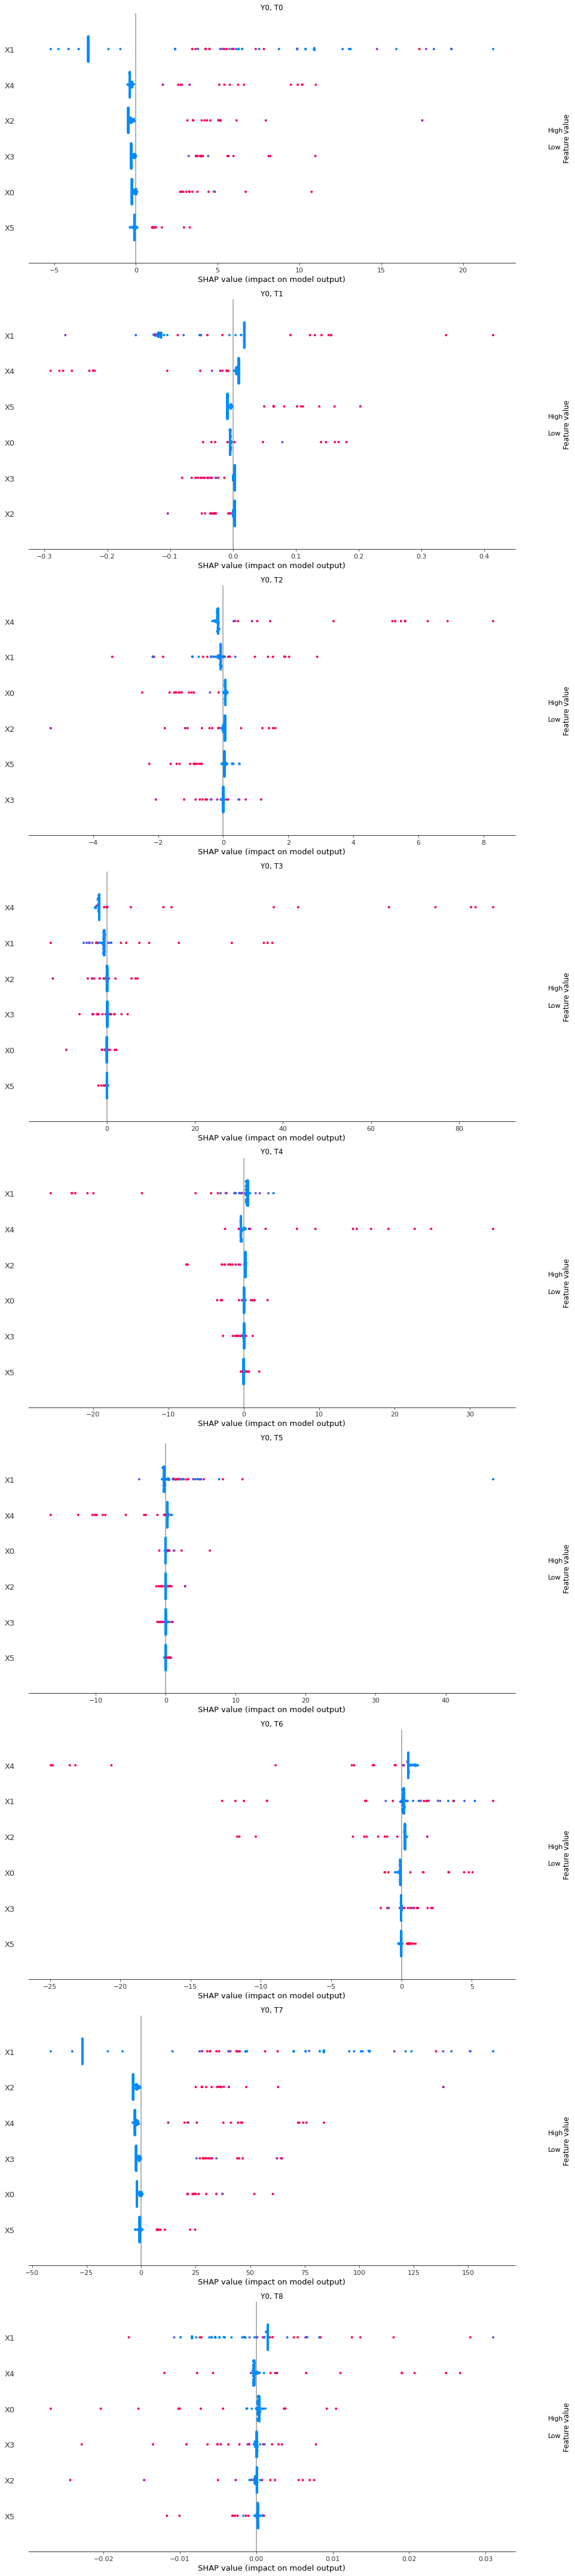

In [74]:
plt.figure(figsize=(15, 60))
for j in range(n_treatments):
    for i in range(n_outputs):
        plt.subplot(n_treatments, n_outputs, i + j * n_outputs + 1)
        plt.title("Y{}, T{}".format(i, j))
        shap.plots.beeswarm(shap_values['Y' + str(i)]['T' + str(j)], plot_size=None, show=False)
plt.tight_layout()
plt.show()

In [152]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 60)
pd.set_option('max_colwidth',1000)

In [153]:
data=pd.read_csv("C:Users/Yazhou Fu/Downloads/shga_shga.csv")

In [171]:
data.head(1)

,IDNO,RNAME,SEX,NATION,BPLACE,HHPLACE,NPLACE,EDEGREE,RELI,POLI,PROF,MARR,HEIGHT,HEAVY,ESCU,LABELNAMES
0,310107195709153270,李成耀,男,汉,上海市普陀区,上海市青浦区华新镇凤星路1304弄14号,上海市普陀区,大学专科和专科学校,无宗教信仰,NaN,人民警察和公安保卫人员,已婚,174.0,NaN,未服兵役,实有人口


In [170]:
2022-int(data["IDNO"][0][6:10])

In [172]:
data["age"]=data["IDNO"].apply(lambda x : 2022-int(x[6:10]))

In [155]:
data.drop(['PHOTO'],inplace=True,axis=1)
data.drop(['STD_ADDRESS'],inplace=True,axis=1)

In [183]:
m=data[data['SEX'].isin(["研究生",'硕士','女'])]

In [184]:
n=m[m.MARR.isin(["未c婚",'离婚'])]

In [187]:
m.sort_values(by=["age"],inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [196]:
1500*3/100/12

In [192]:
m[500:550]

,IDNO,RNAME,SEX,NATION,BPLACE,HHPLACE,NPLACE,EDEGREE,RELI,POLI,PROF,MARR,HEIGHT,HEAVY,ESCU,LABELNAMES,age
9442,231003199403033522,赵婧,女,汉,黑龙江省牡丹江市阳明区,上海市金山区山阳镇卫零北路800弄240号901室,河北省乐亭县,高中,NaN,NaN,学生,未婚,162.0,NaN,NaN,交通违法 实有人口 警员,28
22932,321283199402060048,顾杏,女,汉,江苏省泰州市泰兴市,上海市黄浦区柳市路1弄5号802室,江苏泰兴市,本科,NaN,NaN,NaN,已婚,165.0,NaN,NaN,警员 实有人口,28
48040,310114199402221621,王佳妮,女,汉,上海市嘉定区,上海市嘉定区马陆镇封周路158弄26号,上海市嘉定区,高中,无宗教信仰,NaN,学生,已婚,163.0,NaN,NaN,实有人口 警员 常住人口 交通违法,28
2572,31022719941029182X,焦孝思,女,汉,上海市松江县,上海市松江区广富林路1188弄125号1102室,上海市松江县,学龄前儿童,无宗教信仰,NaN,NaN,已婚,0.0,NaN,未服兵役,警员 实有人口,28
61324,341226199401163324,江晓梅,女,汉,安徽省阜阳市颍上县,上海市崇明区向化镇向卫路30弄48-2号501室,安徽颍上县,高中,NaN,NaN,学生,已婚,170.0,NaN,NaN,交通违法 常住人口 警员 实有人口,28
12045,342921199411061628,陈静,女,汉,安徽省东至县,上海市浦东新区源深路200号乙,安徽省东至县,本科,NaN,NaN,NaN,未婚,160.0,NaN,NaN,交通违法 实有人口 警员 常住人口,28
16369,310225199401020048,周名子,女,汉,上海市浦东新区,上海市浦东新区惠南镇城北村1266号2室,上海市浦东新区,初中,NaN,NaN,学生,未婚,170.0,NaN,NaN,实有人口 交通违法 警员,28
23096,310229199411173422,赵轶慧,女,汉,上海市青浦县,上海市青浦区练塘镇蒸昌路20弄16号102室,上海市青浦县,本科,NaN,NaN,学生,未婚,167.0,NaN,NaN,警员 实有人口 交通违法,28
10144,310230199405205366,张依嘉,女,汉,上海市崇明县,上海崇明区陈家镇裕安村106号,上海市崇明县,高中,NaN,NaN,学生,未婚,152.0,NaN,NaN,实有人口 警员,28
9494,320323199406087924,申畅,女,汉,江苏省徐州市铜山县,上海市黄浦区建国西路75号,江苏铜山县,研究生,NaN,NaN,人民警察和公安保卫人员,未婚,165.0,NaN,未服兵役,警员 交通违法 实有人口 常住人口,28


In [112]:
label= ['SEX', 'NATION', 'BPLACE', 'NPLACE','EDEGREE', 'RELI','PROF', 'MARR', 'ESCU', 'LABELNAMES']

In [146]:
for i in label:
    print(m[i].value_counts())
    print("\n\n")

女    8523
Name: SEX, dtype: int64



汉      8258
回        55
满        27
蒙古        7
苗         4
藏         2
彝         2
达斡尔       2
土家        1
傣         1
俄罗斯       1
瑶         1
锡伯        1
Name: NATION, dtype: int64



上海市浦东新区       724
上海市杨浦区        619
上海市普陀区        481
上海市徐汇区        472
上海市长宁区        459
             ... 
江苏省苏州市张家港市      1
安徽省巢湖地区庐江县      1
福建省宁德地区周宁县      1
湖南省常德市安乡县       1
山东省济宁市嘉祥县       1
Name: BPLACE, Length: 733, dtype: int64



上海市浦东新区    772
上海市        567
上海市崇明县     316
上海市青浦县     214
上海市奉贤县     210
          ... 
山东青岛市        1
河北省蠡县        1
天津市塘沽区       1
辽宁省兴城市       1
四川省蓬溪县       1
Name: NPLACE, Length: 1134, dtype: int64



本科                       2783
大学专科和专科学校                1380
高中                       1350
大专                        521
初中                        518
中等专科学校(简称"中专"或中等技术学校(     388
研究生                       245
中专                        234
小学                        188
中专毕业                      177
学龄前儿童                      

In [109]:
data.columns

Index(['IDNO', 'RNAME', 'SEX', 'NATION', 'BPLACE', 'HHPLACE', 'NPLACE',
       'STD_ADDRESS', 'EDEGREE', 'RELI', 'POLI', 'PROF', 'MARR', 'HEIGHT',
       'HEAVY', 'ESCU', 'LABELNAMES', 'PHOTO'],
      dtype='object')